Домашнее задание

1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import warnings
warnings.filterwarnings('ignore')

In [62]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    for i in range(N):

        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]

        bootstrap.append((b_data, b_labels))

    return bootstrap

In [63]:
def get_subsample(len_sample):

    sample_indexes = list(range(len_sample))
    len_subsample = int(np.sqrt(len_sample))
    subsample = np.random.choice(sample_indexes, size = len_subsample, replace=False)

    return subsample

In [64]:
class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch        

In [65]:
class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):

        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
    
        prediction = max(classes, key = classes.get)
        return prediction

In [66]:
def gini(labels):

    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p**2

    return impurity

In [67]:
def gain(left_labels, right_labels, root_criterion, criterion):

    p = float(left_labels.shape[0] / (left_labels.shape[0] + right_labels.shape[0]))

    return root_criterion - p * criterion(left_labels) - (1 -p) * criterion(right_labels)

In [68]:
def split(data, labels, column_index, t):

    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [69]:
def find_best_split(data, labels):

    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    feature_subsample_indices = get_subsample(n_features)

    for index in feature_subsample_indices:
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue

            current_gain = gain(true_labels, false_labels, root_gini, gini)

            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
    
    return best_gain, best_t, best_index

In [82]:
def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)


    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)


    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)


    return Node(index, t, true_branch, false_branch)

In [71]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))

    return forest

In [72]:
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.true_branch)

In [73]:
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [74]:
def tree_vote(forest, data):

    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    predictions_per_object = list(zip(*predictions))

    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj),  key=obj.count))
    
    return voted_predictions


In [75]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100

1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [76]:
classification_data, classification_labels = make_classification(n_samples = 1000, n_features = 2, n_informative = 2,
                                                                n_classes = 2, n_redundant = 0, n_clusters_per_class = 1, 
                                                                random_state = 3)

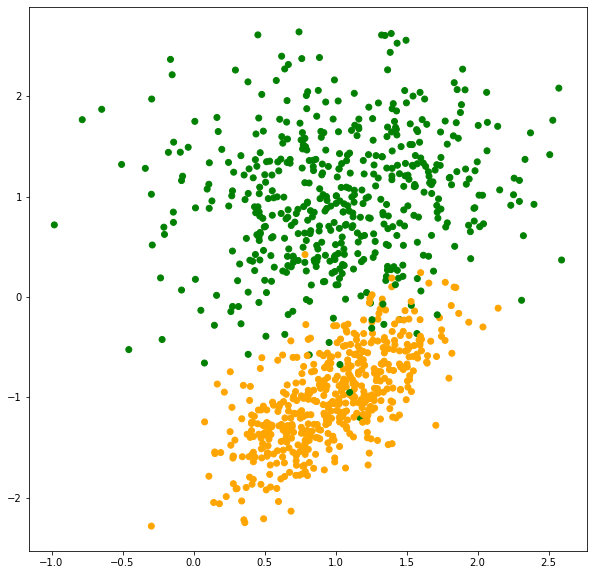

In [77]:
colors = ListedColormap(['green', 'orange'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize = (10, 10))
plt.scatter(classification_data[:, 0], classification_data[:, 1], c = classification_labels, cmap = colors);

In [78]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [80]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, train_labels, test_data, test_labels, my_forest):
    plt.figure(figsize = (16, 7))


    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    
    train_accuracy = accuracy_metric(train_labels, tree_vote(my_forest, train_data))
    plt.title(f'Train accuracy={train_accuracy:.2f}')


    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    
    test_accuracy = accuracy_metric(test_labels, tree_vote(my_forest, test_data))
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [83]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

CPU times: total: 281 ms
Wall time: 287 ms


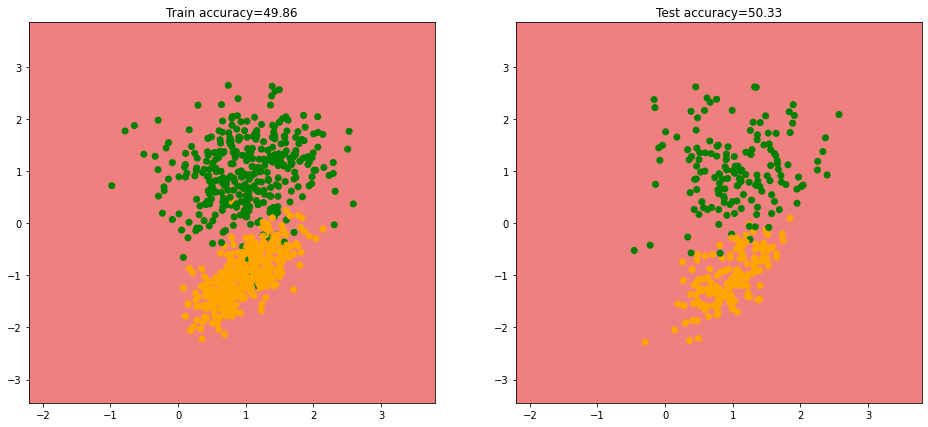

In [84]:
visualize(train_data, train_labels, test_data, test_labels, my_forest_1)

CPU times: total: 984 ms
Wall time: 986 ms


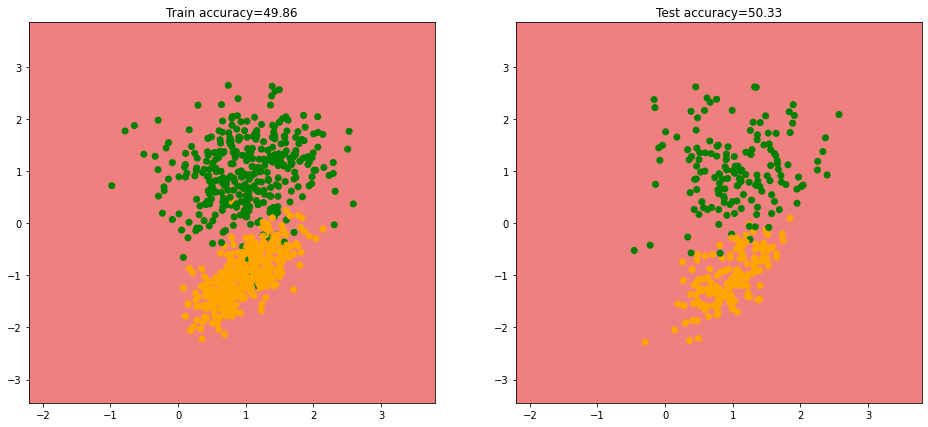

In [85]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)
visualize(train_data, train_labels, test_data, test_labels, my_forest_3)

CPU times: total: 2.88 s
Wall time: 2.89 s


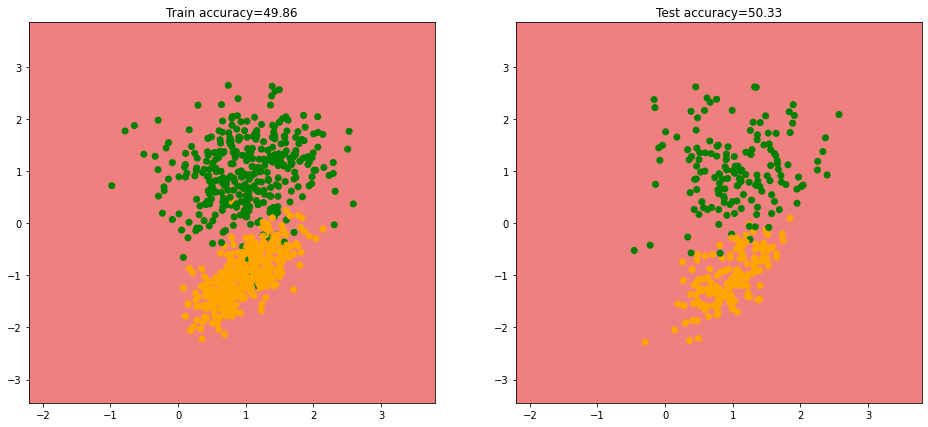

In [86]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)
visualize(train_data, train_labels, test_data, test_labels, my_forest_10)

CPU times: total: 14.8 s
Wall time: 14.9 s


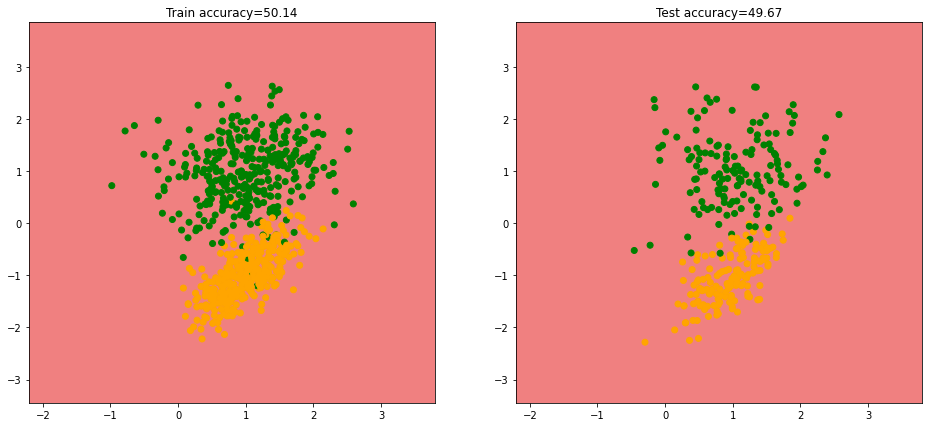

In [87]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)
visualize(train_data, train_labels, test_data, test_labels, my_forest_50)

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [89]:
from tqdm import tqdm


train_accs = []
test_accs = []

for i in tqdm(range(1, 51)):
    my_forest = random_forest(train_data, train_labels, n_trees=i)
    train_accs.append(accuracy_metric(train_labels, tree_vote(my_forest, train_data)))
    test_accs.append(accuracy_metric(test_labels, tree_vote(my_forest, test_data)))

100%|██████████| 50/50 [05:19<00:00,  6.40s/it]


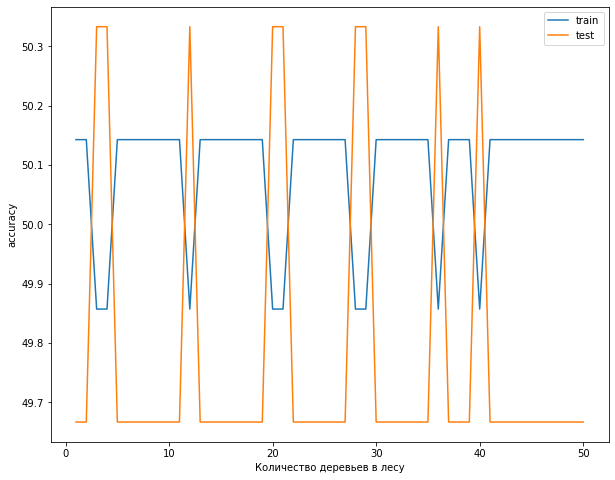

In [90]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 51), train_accs, label='train')
plt.plot(range(1, 51), test_accs, label='test')
plt.xlabel('Количество деревьев в лесу')
plt.ylabel('accuracy')
plt.legend();